# Dividir Datos en entrenamiento y testeo

In [1]:
import os
import random
import shutil

# Ruta de origen: contiene subcarpetas con las clases
ruta_origen = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\DATA\Data_Augmentacion"

# Ruta de destino donde se realizará la división
ruta_destino = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\Result\Split"

# Porcentaje de archivos para entrenamiento
porcentaje_entrenamiento = 0.90

# Crear las carpetas principales "train" y "test" en la ruta de destino
ruta_train = os.path.join(ruta_destino, "train")
ruta_test = os.path.join(ruta_destino, "test")
os.makedirs(ruta_train, exist_ok=True)
os.makedirs(ruta_test, exist_ok=True)

# Recorrer cada subcarpeta (clase) en la ruta de origen
for nombre_clase in os.listdir(ruta_origen):
    ruta_clase = os.path.join(ruta_origen, nombre_clase)
    if os.path.isdir(ruta_clase):
        # Listar todos los archivos dentro de la subcarpeta (asumiendo que son imágenes)
        archivos = [archivo for archivo in os.listdir(ruta_clase)
                    if os.path.isfile(os.path.join(ruta_clase, archivo))]
        
        # Mezclar aleatoriamente la lista de archivos
        random.shuffle(archivos)
        
        # Calcular cantidad de archivos para entrenamiento y testeo
        total_archivos = len(archivos)
        num_entrenamiento = int(total_archivos * porcentaje_entrenamiento)
        
        archivos_entrenamiento = archivos[:num_entrenamiento]
        archivos_testeo = archivos[num_entrenamiento:]
        
        # Crear las subcarpetas correspondientes en "train" y "test" para esta clase
        destino_train_clase = os.path.join(ruta_train, nombre_clase)
        destino_test_clase = os.path.join(ruta_test, nombre_clase)
        os.makedirs(destino_train_clase, exist_ok=True)
        os.makedirs(destino_test_clase, exist_ok=True)
        
        # Copiar archivos de entrenamiento
        for archivo in archivos_entrenamiento:
            origen = os.path.join(ruta_clase, archivo)
            destino = os.path.join(destino_train_clase, archivo)
            shutil.copy2(origen, destino)
        
        # Copiar archivos de testeo
        for archivo in archivos_testeo:
            origen = os.path.join(ruta_clase, archivo)
            destino = os.path.join(destino_test_clase, archivo)
            shutil.copy2(origen, destino)
        
        print(f"Clase '{nombre_clase}': {len(archivos_entrenamiento)} archivos en entrenamiento y {len(archivos_testeo)} archivos en testeo.")

Clase 'BI': 1166 archivos en entrenamiento y 130 archivos en testeo.
Clase 'EM': 720 archivos en entrenamiento y 80 archivos en testeo.
Clase 'S': 1080 archivos en entrenamiento y 120 archivos en testeo.
Clase 'TM': 1325 archivos en entrenamiento y 148 archivos en testeo.
Clase 'VM': 1274 archivos en entrenamiento y 142 archivos en testeo.


# Validacion cruzada

In [2]:
import os
import numpy as np
import shutil

# --- CONFIGURACIÓN DE RUTAS Y PARÁMETROS ---
base_dir = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\Result\Split\train"
output_base = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\Result\cv_5_folds"
n_folds = 5

# Crear la carpeta de salida si no existe
os.makedirs(output_base, exist_ok=True)

# --- OBTENER LAS CLASES E IMÁGENES ---
# Listar las subcarpetas (clases) en la carpeta base
class_folders = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print("Clases encontradas:", class_folders)

# Diccionario para almacenar la lista de imágenes de cada clase
class_files = {}
for cls in class_folders:
    cls_path = os.path.join(base_dir, cls)
    # Se consideran archivos con extensión .png, .jpg o .jpeg
    files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_files[cls] = files

# Contar imágenes totales (para verificar que suman 1935)
total_images = sum(len(files) for files in class_files.values())
print(f"Total de imágenes en '{base_dir}': {total_images}")

# --- DIVIDIR LAS IMÁGENES EN 5 FOLDS (VALIDACIÓN) DE FORMA ESTRATIFICADA ---
# Para cada clase se barajan y se dividen las imágenes en n_folds partes disjuntas.
fold_assignments = {i: {} for i in range(n_folds)}  # fold_assignments[i][cls] = lista de imágenes de la clase para el fold i

for cls, files in class_files.items():
    files = np.array(files)
    indices = np.arange(len(files))
    np.random.shuffle(indices)
    # Dividir los índices en n_folds partes (los tamaños pueden diferir en 1 imagen)
    split_indices = np.array_split(indices, n_folds)
    for i in range(n_folds):
        # Convertir a lista de rutas para la clase cls en el fold i
        fold_assignments[i][cls] = files[split_indices[i]].tolist()

# --- CREAR LA ESTRUCTURA DE SALIDA Y COPIAR LAS IMÁGENES ---
for i in range(n_folds):
    fold_num = i + 1
    fold_dir = os.path.join(output_base, f"fold_{fold_num}")
    os.makedirs(fold_dir, exist_ok=True)
    
    # Crear subcarpetas para cada clase dentro del fold
    for cls in class_folders:
        os.makedirs(os.path.join(fold_dir, cls), exist_ok=True)
    
    # Copiar las imágenes asignadas a este fold
    for cls in class_folders:
        for file_path in fold_assignments[i][cls]:
            dest_path = os.path.join(fold_dir, cls, os.path.basename(file_path))
            shutil.copy2(file_path, dest_path)
    
    # Contar imágenes copiadas en el fold actual
    fold_count = sum(len(os.listdir(os.path.join(fold_dir, cls))) for cls in class_folders)
    print(f"Fold {fold_num} creado: {fold_count} imágenes.")

# Verificar que la suma de imágenes en los 5 folds es igual al total original
total_fold_images = 0
for i in range(n_folds):
    fold_dir = os.path.join(output_base, f"fold_{i+1}")
    fold_count = sum(len(os.listdir(os.path.join(fold_dir, cls))) for cls in class_folders)
    total_fold_images += fold_count
print(f"Total de imágenes sumadas en los 5 folds: {total_fold_images}")

Clases encontradas: ['BI', 'EM', 'S', 'TM', 'VM']
Total de imágenes en 'C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\Result\Split\train': 5565
Fold 1 creado: 1114 imágenes.
Fold 2 creado: 1113 imágenes.
Fold 3 creado: 1113 imágenes.
Fold 4 creado: 1113 imágenes.
Fold 5 creado: 1112 imágenes.
Total de imágenes sumadas en los 5 folds: 5565


# Visualizacion de uno de los Fold

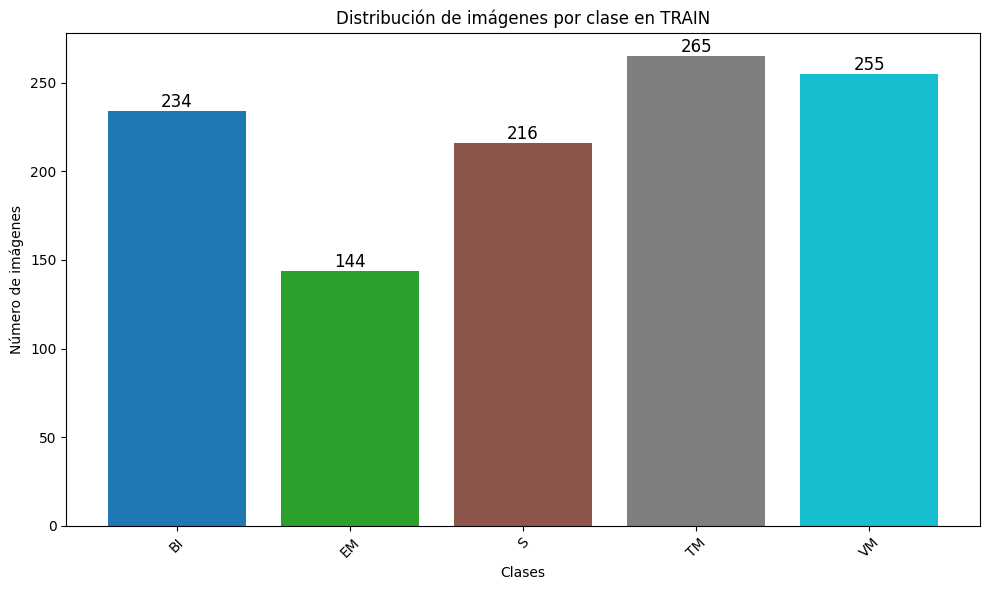

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ruta de la carpeta de entrenamiento
ruta_train = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\Result\cv_5_folds\fold_1"

# Obtener la lista de clases (subcarpetas)
clases = [folder for folder in os.listdir(ruta_train) 
          if os.path.isdir(os.path.join(ruta_train, folder))]

# Contar el número de imágenes en cada clase
conteos = []
for clase in clases:
    ruta_clase = os.path.join(ruta_train, clase)
    num_imagenes = len([f for f in os.listdir(ruta_clase)
                        if os.path.isfile(os.path.join(ruta_clase, f))])
    conteos.append(num_imagenes)

# Configurar el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Asignar un color distinto a cada barra usando una colormap
# Se usa 'tab10', que proporciona 10 colores distintos; si tienes más clases, puedes cambiar a 'tab20' u otro cmap.
colors = plt.cm.tab10(np.linspace(0, 1, len(clases)))

barras = ax.bar(clases, conteos, color=colors)

# Agregar el número de imágenes sobre cada barra
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, f'{int(altura)}', 
            ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Clases')
ax.set_ylabel('Número de imágenes')
ax.set_title('Distribución de imágenes por clase en TRAIN')
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario para mayor claridad
plt.tight_layout()
plt.show()